Implement various metrics to evaluate the performance of the RL model & H-network on how good they can mask user's load

Tentative metrics

Privacy metrics
- Mutual Information (either follows paper's evaluation, or other methods?)
- Matthews correlation coefficient (MCC) ? But we need to train an attacker as well. (Ruichang used this in a previous paper, PLS-DDPG)
- KL-divergence? Should be easy to compute

Monetary Cost metrics
- Compute the extra cost incured for the battery operation (i.e. compute the masked load vs original grid load)

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
from datetime import datetime
import json
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
import matplotlib
# matplotlib.use('Agg')       # Use non-interactive backend for matplotlib to save memory

from utils import print_log

In [2]:
%load_ext autoreload
%autoreload 2

---

Load the train/valid/test per-episode log

In [3]:
expt_datetime = datetime(2025, 7, 29, 2, 12, 21)
result_phrase = "train"  # or "test" or "validate"

expt_folder = Path("experiments") / expt_datetime.strftime("%Y%m%d_%H%M%S") / ("logs_" + result_phrase)

if not expt_folder.exists():
    print_log(f"Experiment folder {expt_folder} does not exist. Please check the path.", "error")

In [4]:
env_config_path = expt_folder.parent / "env_config.json"
if not env_config_path.exists():
    print_log(f"Environment config file {env_config_path} does not exist. Please check the path.", "error")

# Load environment configuration
with open(env_config_path, 'r') as f:
    env_config = json.load(f)

# Display environment configuration
print_log("Environment Configuration:")
for key, value in env_config.items():
    print_log(f"{key}: {value}")

[2025-07-29 03:31:17:282] Environment Configuration:
[2025-07-29 03:31:17:282] battery: {'capacity': 8.0, 'max_charging_rate': 4.0, 'efficiency': 1.0, 'initial_soc': 0.15}
[2025-07-29 03:31:17:282] reward_lambda: 0.5
[2025-07-29 03:31:17:282] h_network_type: HNetworkType.H_NETWORK
[2025-07-29 03:31:17:282] init_soc: 0.15
[2025-07-29 03:31:17:282] data_loader_type: SimpleSmartMeterDataLoader
[2025-07-29 03:31:17:283] curriculum_info: {'curriculum_enabled': False, 'max_episode_days': 1, 'episodes_by_length': {'1': 162}, 'total_episodes': 162, 'registry_path': 'experiments/20250729_021221/simple_episode_registry_train.json', 'data_loader_type': 'simple'}
[2025-07-29 03:31:17:283] training_timestep: 3


In [5]:
max_battery_capacity = env_config.get("battery").get("capacity", 8)
# max_battery_capacity = 8

max_battery_capacity

8.0

In [6]:
from collections.abc import MutableMapping

def flatten(dictionary, parent_key='', separator='_'):
    items = []
    for key, value in dictionary.items():
        new_key = parent_key + separator + key if parent_key else key
        if isinstance(value, MutableMapping):
            items.extend(flatten(value, new_key, separator=separator).items())
        else:
            items.append((new_key, value))
    return dict(items)

In [7]:
episode_info_folder = expt_folder / "episode_info"
if episode_info_folder.exists():
    episode_info_files = sorted(list(episode_info_folder.glob("*.json")))
    episode_info_dfs = []
    episode_metadata_list = []  # Store metadata for each episode

    for file in episode_info_files:
        with open(file, "r") as f:
            episode_info = json.load(f)
            
            # Extract episode data and metadata (support new format)
            if isinstance(episode_info, dict) and 'episode_data' in episode_info:
                # New format with metadata
                episode_data = episode_info['episode_data']
                metadata = episode_info.get('metadata', {})
                df = pd.DataFrame(episode_data)

                metadata = flatten(metadata)  # Flatten metadata dictionary
                
                # Store metadata for analysis
                episode_metadata_list.append({
                    'episode_file': file.name,
                    'episode_idx': int(file.stem.split('_')[1]),
                    **metadata
                })
            else:
                # Legacy format - just episode data
                df = pd.DataFrame(episode_info)
                episode_metadata_list.append({
                    'episode_file': file.name,
                    'episode_idx': int(file.stem.split('_')[1]),
                    'episode_content_id': None,
                    'episode_length_days': 1,  # Default to 1 day for legacy
                    'curriculum_phase': None,
                    'data_loader_type': 'Unknown'
                })
            
            # add a column for the episode number
            df['episode'] = int(file.stem.split('_')[1])  # Assuming the file name is like "episode_0_info.json", "episode_1_info.json", etc.
            # convert the datetime strings to datetime objects using python isoformat
            df['datetime'] = pd.to_datetime(df['datetime'], format='ISO8601')

            # fix to align with episode_df.pkl
            # we shift "grid_load (W)", "action (kW)", "battery_action (kW)", "reward", "f_signal", "g_signal" columns to the a timestep forward, then drop the last row for each episode
            df['grid_load (W)'] = df['grid_load (W)'].shift(-1)
            df['action (kW)'] = df['action (kW)'].shift(-1)
            df['battery_action (kW)'] = df['battery_action (kW)'].shift(-1)
            df['reward'] = df['reward'].shift(-1)
            df['f_signal'] = df['f_signal'].shift(-1)
            df['g_signal'] = df['g_signal'].shift(-1)
            df['f_signal-predicted_mean'] = df['f_signal-predicted_mean'].shift(-1)
            df['f_signal-predicted_log_var'] = df['f_signal-predicted_log_var'].shift(-1)
            df['f_signal-target'] = df['f_signal-target'].shift(-1)

            # remove the last row for each episode
            df = df[:-1]

            episode_info_dfs.append(df)

            print_log(f"Loaded episode info from {file.name}")

    # Concatenate all DataFrames into one
    episode_info_df = pd.concat(episode_info_dfs, ignore_index=True)
    
    # Create episode metadata DataFrame for curriculum analysis
    episode_metadata_df = pd.DataFrame(episode_metadata_list)
    
    print_log(f"Loaded {len(episode_info_dfs)} episodes with enhanced metadata")
    print_log(f"Data loader types found: {episode_metadata_df['curriculum_info_data_loader_type'].value_counts().to_dict()}")
    if 'episode_length_days' in episode_metadata_df.columns:
        print_log(f"Episode lengths found: {episode_metadata_df['episode_length_days'].value_counts().sort_index().to_dict()}")
    # if 'curriculum_phase' in episode_metadata_df.columns and episode_metadata_df['curriculum_phase'].notna().any():
    #     print_log(f"Curriculum phases found: {episode_metadata_df['curriculum_phase'].value_counts().to_dict()}")

[2025-07-29 03:31:18:544] Loaded episode info from episode_0001_info.json
[2025-07-29 03:31:18:579] Loaded episode info from episode_0002_info.json
[2025-07-29 03:31:18:613] Loaded episode info from episode_0003_info.json
[2025-07-29 03:31:18:651] Loaded episode info from episode_0004_info.json
[2025-07-29 03:31:18:685] Loaded episode info from episode_0005_info.json
[2025-07-29 03:31:18:718] Loaded episode info from episode_0006_info.json
[2025-07-29 03:31:18:755] Loaded episode info from episode_0007_info.json
[2025-07-29 03:31:18:791] Loaded episode info from episode_0008_info.json
[2025-07-29 03:31:18:825] Loaded episode info from episode_0009_info.json
[2025-07-29 03:31:18:862] Loaded episode info from episode_0010_info.json
[2025-07-29 03:31:18:894] Loaded episode info from episode_0011_info.json
[2025-07-29 03:31:18:929] Loaded episode info from episode_0012_info.json
[2025-07-29 03:31:18:965] Loaded episode info from episode_0013_info.json
[2025-07-29 03:31:19:064] Loaded episo

In [8]:
episode_info_dfs[0]

,episode_index,current_step,datetime,battery_soc (%),battery_soc (kWh),user_load (W),grid_load (W),action (kW),battery_action (kW),reward,f_signal,g_signal,f_signal-predicted_mean,f_signal-predicted_log_var,f_signal-target,TimeLimit.truncated,episode
0,96,0,2013-08-28 00:00:02,0.150000,1.200000,300.0,1750.0,1.45,1.45,0.022870,-0.049252,0.003512,44.0,"[0.05022026598453522, -0.07411113381385803, 0....",6.0,NaN,1
1,96,1,2013-08-28 00:01:02,0.153021,1.224167,300.0,1050.0,0.75,0.75,0.023612,-0.049199,0.001975,44.0,"[0.043651923537254333, -0.06479000300168991, 0...",6.0,False,1
2,96,2,2013-08-28 00:02:02,0.154583,1.236667,300.0,0.0,-3.60,-0.30,0.024046,-0.049078,0.000987,69.0,"[0.03968516364693642, -0.052148137241601944, 0...",6.0,False,1
3,96,3,2013-08-28 00:03:02,0.153958,1.231667,300.0,3600.0,3.30,3.30,0.020667,-0.048907,0.007572,44.0,"[0.0363374687731266, -0.08480299264192581, 0.0...",6.0,False,1
4,96,4,2013-08-28 00:04:02,0.160833,1.286667,300.0,0.0,-2.25,-0.30,0.023978,-0.048943,0.000987,69.0,"[0.03495488315820694, -0.05697784572839737, 0....",6.0,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1434,96,1434,2013-08-28 23:54:02,0.999583,7.996666,200.0,0.0,-0.70,-0.20,0.021361,-0.044075,0.001354,69.0,"[0.01339244470000267, -0.06454483419656754, 0....",4.0,False,1
1435,96,1435,2013-08-28 23:55:02,0.999167,7.993333,200.0,0.0,-3.40,-0.20,0.021385,-0.044124,0.001354,69.0,"[0.01395302265882492, -0.06563329696655273, 0....",4.0,False,1
1436,96,1436,2013-08-28 23:56:02,0.998750,7.990000,200.0,800.0,1.55,0.60,0.020201,-0.043806,0.003404,69.0,"[0.0123109370470047, -0.07110528647899628, -0....",4.0,False,1
1437,96,1437,2013-08-28 23:57:02,1.000000,8.000000,200.0,0.0,-3.90,-0.20,0.020376,-0.042106,0.001354,69.0,"[0.01211557537317276, -0.06505394726991653, 0....",3.0,False,1


In [9]:
# Create curriculum-aware episode groupings for enhanced analysis
grouped_by_content_id = {}
grouped_by_episode_length = {}
grouped_by_curriculum_phase = {}

if 'episode_metadata_df' in locals():
    print_log("Creating curriculum-aware episode groupings...")
    
    for i, episode_df in enumerate(episode_info_dfs):
        episode_iteration = int(episode_df['episode'].iloc[0])  # Episode iteration number
        
        # Find corresponding metadata
        metadata = episode_metadata_df[episode_metadata_df['episode_idx'] == episode_iteration]
        
        if len(metadata) > 0:
            metadata_row = metadata.iloc[0]
            
            # Group by content ID
            content_id = metadata_row.get('episode_content_id', f'unknown_{episode_iteration}')
            if content_id not in grouped_by_content_id:
                grouped_by_content_id[content_id] = []
            grouped_by_content_id[content_id].append(i)
            
            # Group by episode length
            episode_length = metadata_row.get('episode_length_days', 1)
            if episode_length not in grouped_by_episode_length:
                grouped_by_episode_length[episode_length] = []
            grouped_by_episode_length[episode_length].append(i)
            
            # Group by curriculum phase (if available)
            curriculum_phase = metadata_row.get('curriculum_phase')
            if curriculum_phase is not None:
                if curriculum_phase not in grouped_by_curriculum_phase:
                    grouped_by_curriculum_phase[curriculum_phase] = []
                grouped_by_curriculum_phase[curriculum_phase].append(i)

    print_log(f"Episode grouping summary for privacy-cost analysis:")
    print_log(f"- By content ID: {len(grouped_by_content_id)} unique episode contents")
    print_log(f"- By episode length: {len(grouped_by_episode_length)} different lengths: {list(grouped_by_episode_length.keys())}")
    print_log(f"- By curriculum phase: {len(grouped_by_curriculum_phase)} phases: {list(grouped_by_curriculum_phase.keys())}")
    
    # Display examples of repeated episode contents for evaluation
    repeated_contents = {k: v for k, v in grouped_by_content_id.items() if len(v) > 1}
    if len(repeated_contents) > 0:
        print_log(f"Found {len(repeated_contents)} episode contents that appear multiple times:")
        for content_id, episode_indices in list(repeated_contents.items())[:3]:  # Show first 3 examples
            if content_id != 'unknown_0':
                print_log(f"  Content {content_id[:8]}... appears in episodes: {episode_indices}")
    else:
        print_log("No repeated episode content found (each episode is unique)")
else:
    print_log("No episode metadata available - using legacy evaluation format")

[2025-07-29 03:31:24:580] Creating curriculum-aware episode groupings...
[2025-07-29 03:31:24:613] Episode grouping summary for privacy-cost analysis:
[2025-07-29 03:31:24:613] - By content ID: 93 unique episode contents
[2025-07-29 03:31:24:613] - By episode length: 1 different lengths: [1]
[2025-07-29 03:31:24:613] - By curriculum phase: 0 phases: []
[2025-07-29 03:31:24:613] Found 40 episode contents that appear multiple times:
[2025-07-29 03:31:24:613]   Content a5a8920f... appears in episodes: [2, 148]
[2025-07-29 03:31:24:613]   Content a11dd786... appears in episodes: [3, 63]
[2025-07-29 03:31:24:613]   Content 778384fa... appears in episodes: [4, 54, 101]


Run the following cells

Mutual Information implementation

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html

In the paper `Privacy-Cost Management in Smart Meters With Mutual-Information-Based Reinforcement Learning`, the parameter $k$ (in KNN estimation) is set to 4

X will be the masked grid load; y will be the user load

In [10]:
def calculate_mutual_information_per_episode(episode_info_dfs, k=4):
    """
    Calculate mutual information between masked grid load and user load for each episode.
    
    Args:
        episode_info_dfs: List of episode DataFrames
        k: Number of neighbors for KNN estimation (default=4 as per paper)
    
    Returns:
        Dictionary containing:
        - 'mi_values': List of mutual information values for each episode
        - 'episode_indices': List of episode indices from the dataset
        - 'episode_info_indices': List of indices in the episode_info_dfs list
    """
    mi_results = {
        'mi_values': [],
        'episode_indices': [],
        'episode_info_indices': []
    }
    
    for i, episode_df in enumerate(episode_info_dfs):
        try:
            # Get the episode index from the dataframe
            episode_idx = episode_df['episode_index'].iloc[0] if 'episode_index' in episode_df.columns else episode_df['episode'].iloc[0]
            
            # Create a copy to avoid modifying the original dataframe
            df_clean = episode_df.copy()
            
            # Remove rows with NaN values in either grid_load or user_load columns
            df_clean = df_clean.dropna(subset=['grid_load (W)', 'user_load (W)'])
            
            # Check if we have enough data points after removing NaN values
            if len(df_clean) < k + 1:  # Need at least k+1 points for KNN
                print_log(f"Episode {i} (episode_idx: {episode_idx}): Not enough valid data points ({len(df_clean)}) after removing NaN values")
                mi_results['mi_values'].append(np.nan)
                mi_results['episode_indices'].append(episode_idx)
                mi_results['episode_info_indices'].append(i)
                continue
            
            # Extract the features: masked grid load (X) and user load (y)
            X = df_clean['grid_load (W)'].values.reshape(-1, 1)  # Masked grid load (features)
            y = df_clean['user_load (W)'].values  # User load (continuous target)
            
            # Calculate mutual information using scikit-learn for regression
            # mutual_info_regression handles continuous variables directly
            mi = mutual_info_regression(X, y, n_neighbors=k, random_state=42)
            
            mi_results['mi_values'].append(mi[0])  # mi is an array, we take the first element
            mi_results['episode_indices'].append(episode_idx)
            mi_results['episode_info_indices'].append(i)
            
            if i % 100 == 0:  # Print progress every 100 episodes
                print_log(f"Processed episode {i}/{len(episode_info_dfs)} (episode_idx: {episode_idx})")

            del df_clean  # Free memory after processing
                
        except Exception as e:
            # Get episode index even in case of error
            episode_idx = episode_df['episode_index'].iloc[0] if 'episode_index' in episode_df.columns else episode_df['episode'].iloc[0] if 'episode' in episode_df.columns else i
            print_log(f"Error calculating MI for episode {i} (episode_idx: {episode_idx}): {str(e)}")
            mi_results['mi_values'].append(np.nan)  # Add NaN for failed calculations
            mi_results['episode_indices'].append(episode_idx)
            mi_results['episode_info_indices'].append(i)
    
    print_log(f"Calculated mutual information for {len(mi_results['mi_values'])} episodes")
    return mi_results

In [11]:
# Calculate mutual information for all episodes with enhanced metadata
print_log("Starting mutual information calculation with curriculum learning support...")
mi_results = calculate_mutual_information_per_episode(episode_info_dfs, k=4)

# Extract the components from the results
mutual_info_values = mi_results['mi_values']
episode_indices = mi_results['episode_indices']
episode_info_indices = mi_results['episode_info_indices']

# Create a comprehensive DataFrame with episode, episode_index, MI values, and curriculum metadata
mi_df = pd.DataFrame({
    'episode_info_index': episode_info_indices,         # Index in the episode_info_dfs list
    'episode_index': episode_indices,                   # Episode index from the dataset
    'mutual_information': mutual_info_values            # MI values
})

# Add curriculum metadata if available
if 'episode_metadata_df' in locals():
    # Merge with metadata based on episode_index
    # mi_df = mi_df.merge(episode_metadata_df[['episode_idx', 'episode_content_id', 'episode_length_days', 
    #                                         'curriculum_phase', 'data_loader_type']], 
    #                    left_on='episode_index', right_on='episode_idx', how='left')
    mi_df = mi_df.merge(episode_metadata_df[['episode_idx', 'episode_content_id', 'episode_length_days', 
                                            'curriculum_info_data_loader_type']], 
                       left_on='episode_index', right_on='episode_idx', how='left')
    mi_df.drop('episode_idx', axis=1, inplace=True)  # Remove duplicate column
    
    print_log("Enhanced MI DataFrame with curriculum metadata:")
    print_log(f"Columns: {list(mi_df.columns)}")
else:
    print_log("Using basic MI DataFrame (no curriculum metadata available)")

print_log(f"Mutual Information Statistics:")
print_log(f"Mean MI: {np.nanmean(mutual_info_values):.6f}")
print_log(f"Std MI: {np.nanstd(mutual_info_values):.6f}")
print_log(f"Min MI: {np.nanmin(mutual_info_values):.6f}")
print_log(f"Max MI: {np.nanmax(mutual_info_values):.6f}")

print_log(f"DataFrame shape: {mi_df.shape}")
print_log(f"Episode index range: {mi_df['episode_index'].min()} to {mi_df['episode_index'].max()}")

# Display curriculum-aware statistics if available
if 'episode_length_days' in mi_df.columns:
    print_log("\nMutual Information by Episode Length:")
    mi_by_length = mi_df.groupby('episode_length_days')['mutual_information'].agg(['count', 'mean', 'std']).round(6)
    print_log(mi_by_length.to_string())

if 'curriculum_phase' in mi_df.columns and mi_df['curriculum_phase'].notna().any():
    print_log("\nMutual Information by Curriculum Phase:")
    mi_by_phase = mi_df.groupby('curriculum_phase')['mutual_information'].agg(['count', 'mean', 'std']).round(6)
    print_log(mi_by_phase.to_string())

mi_df

[2025-07-29 03:31:30:452] Starting mutual information calculation with curriculum learning support...
[2025-07-29 03:31:30:467] Processed episode 0/151 (episode_idx: 96)
[2025-07-29 03:31:30:905] Processed episode 100/151 (episode_idx: 42)
[2025-07-29 03:31:31:129] Calculated mutual information for 151 episodes
[2025-07-29 03:31:31:133] Enhanced MI DataFrame with curriculum metadata:
[2025-07-29 03:31:31:133] Columns: ['episode_info_index', 'episode_index', 'mutual_information', 'episode_content_id', 'episode_length_days', 'curriculum_info_data_loader_type']
[2025-07-29 03:31:31:133] Mutual Information Statistics:
[2025-07-29 03:31:31:133] Mean MI: 1.033470
[2025-07-29 03:31:31:133] Std MI: 0.447625
[2025-07-29 03:31:31:133] Min MI: 0.016865
[2025-07-29 03:31:31:133] Max MI: 1.957731
[2025-07-29 03:31:31:133] DataFrame shape: (151, 6)
[2025-07-29 03:31:31:133] Episode index range: 0 to 157
[2025-07-29 03:31:31:133] 
Mutual Information by Episode Length:
[2025-07-29 03:31:31:135]       

,episode_info_index,episode_index,mutual_information,episode_content_id,episode_length_days,curriculum_info_data_loader_type
0,0,96,0.336408,564703eba723,1.0,simple
1,1,8,0.592499,5a90f90f8776,1.0,simple
2,2,147,0.553686,d43e391cf44c,1.0,simple
3,3,35,0.699761,7af6a1221800,1.0,simple
4,4,41,0.354600,000bcf1ac6b2,1.0,simple
...,...,...,...,...,...,...
146,146,157,0.406431,NaN,NaN,NaN
147,147,11,0.934274,40216c322e04,1.0,simple
148,148,147,1.770637,d43e391cf44c,1.0,simple
149,149,79,1.142221,09206b476f5b,1.0,simple


Apart from the Mutual Information, we also want to compute the extra cost incurred from our policy

The cost can be computed as

$$\int (B_t - Y_t)h_t \triangle_t$$

where $B_t$ is the battery state of charge at time t; $Y_t$ is the user load at time t, $h_t$ is the time-of-use price per kWh, $\triangle_t$ is the time passed 

To compute the electricity cost, we copy the electricity cost function from our environment and slightly modify it for our purpose

In [12]:
from datetime import time, datetime

def calculate_extra_cost_per_episode(episode_info_dfs):
    """
    Calculate extra electricity cost incurred by battery actions for each episode.
    
    The extra cost is computed using the _g_signal approach where:
    - We calculate the cost difference between masked grid load and user load
    - The difference (grid_load - user_load) represents the battery charging/discharging effect
    - Cost is computed using time-of-use pricing with proper time weighting
    
    Args:
        episode_info_dfs: List of episode DataFrames
    
    Returns:
        Dictionary containing:
        - 'cost_values': List of extra cost values for each episode (in currency units)
        - 'episode_indices': List of episode indices from the dataset
        - 'episode_info_indices': List of indices in the episode_info_dfs list
    """

    standing_charge_per_day = 0.4734 # in GBP

    time_of_use_prices = {
        (time(0,0,0,0), time(7,0,0,0)): 0.1317,              # off-peak price
        (time(7,0,0,0), time(23,59,59,999999)): 0.3075,      # peak price
    }
    
    # Helper function to get weighted electricity cost (adapted from environment)
    def get_weighted_electricity_cost(s_t_datetime:datetime, s_t_plus_1_datetime:datetime) -> float:
        """
        Calculate the weighted electricity cost based on time-of-use pricing.
        Returns: delta_t * avg_price_per_kWh for the time period
        """
        
        # time_of_use_prices = {
        #     (time(0,0,0,0), time(7,0,0,0)): 0.101,  # off-peak price
        #     (time(7,0,0,0), time(11,0,0,0)): 0.208,   # peak price
        #     (time(11,0,0,0), time(17,0,0,0)): 0.144,  # mid-peak price
        #     (time(17,0,0,0), time(19,0,0,0)): 0.208,   # peak price
        #     (time(19,0,0,0), time(23,59,59,999999)): 0.101,  # evening price
        # }


        total_cost = 0.0
        for start_time, end_time in time_of_use_prices.keys():
            if s_t_datetime.time() <= end_time and s_t_plus_1_datetime.time() >= start_time:
                # Calculate the overlap between the time intervals
                overlap_start = max(s_t_datetime, datetime.combine(s_t_datetime.date(), start_time))
                overlap_end = min(s_t_plus_1_datetime, datetime.combine(s_t_plus_1_datetime.date(), end_time))
                
                if overlap_start < overlap_end:
                    overlap_duration = (overlap_end - overlap_start).total_seconds() / 3600.0  # Convert to hours
                    price_per_kwh = time_of_use_prices[(start_time, end_time)]
                    total_cost += overlap_duration * price_per_kwh

        return total_cost
    
    # Improved _g_signal function for cost calculation
    def g_signal(s_t_datetime:datetime, s_t_plus_1_datetime:datetime, power_kw:float) -> float:
        """
        Calculate the cost signal based on elapsed time and power used.
        """
        if s_t_datetime >= s_t_plus_1_datetime:
            return 0.0  # No time elapsed, no cost
        
        weighted_cost = get_weighted_electricity_cost(s_t_datetime, s_t_plus_1_datetime)
        return weighted_cost * power_kw + standing_charge_per_day * ((s_t_plus_1_datetime - s_t_datetime).total_seconds() / (24 * 60 * 60))  # convert seconds to days
    
    cost_results = {
        'cost_values': [],
        'episode_indices': [],
        'episode_info_indices': []
    }
    
    for i, episode_df in enumerate(episode_info_dfs):
        try:
            # Get the episode index from the dataframe
            episode_idx = episode_df['episode_index'].iloc[0] if 'episode_index' in episode_df.columns else episode_df['episode'].iloc[0]
            
            # Create a copy to avoid modifying the original dataframe
            df_clean = episode_df.copy()
            
            # Remove rows with NaN values in required columns
            required_columns = ['grid_load (W)', 'user_load (W)', 'datetime']
            df_clean = df_clean.dropna(subset=required_columns)
            
            # Check if we have enough data points
            if len(df_clean) < 2:  # Need at least 2 points to calculate time differences
                print_log(f"Episode {i} (episode_idx: {episode_idx}): Not enough valid data points ({len(df_clean)}) after removing NaN values")
                cost_results['cost_values'].append(np.nan)
                cost_results['episode_indices'].append(episode_idx)
                cost_results['episode_info_indices'].append(i)
                continue
            
            # Sort by datetime to ensure proper time ordering
            df_clean = df_clean.sort_values('datetime').reset_index(drop=True)
            
            total_extra_cost = 0.0
            total_grid_cost = 0.0  # Cost of actual grid consumption
            total_user_cost = 0.0  # Cost if no battery was used
            
            # Calculate cost for each time step using _g_signal approach
            for j in range(len(df_clean) - 1):
                # Current and next timestamps
                current_time = df_clean.iloc[j]['datetime']
                next_time = df_clean.iloc[j + 1]['datetime']
                
                # Power values (convert from W to kW)
                grid_load_kw = df_clean.iloc[j]['grid_load (W)'] / 1000.0
                user_load_kw = df_clean.iloc[j]['user_load (W)'] / 1000.0
                
                # Calculate costs using g_signal approach
                grid_cost = g_signal(current_time, next_time, grid_load_kw)
                user_cost = g_signal(current_time, next_time, user_load_kw)
                
                # Accumulate costs
                total_grid_cost += grid_cost
                total_user_cost += user_cost
            
            # Extra cost is the difference between what we actually paid vs what we would have paid
            total_extra_cost = abs(total_grid_cost - total_user_cost)
            
            cost_results['cost_values'].append(total_extra_cost)
            cost_results['episode_indices'].append(episode_idx)
            cost_results['episode_info_indices'].append(i)
            
            if i % 100 == 0:  # Print progress every 100 episodes
                print_log(f"Processed episode {i}/{len(episode_info_dfs)} (episode_idx: {episode_idx}), Extra cost: £{total_extra_cost:.4f}")

            del df_clean  # Free memory after processing
                
        except Exception as e:
            # Get episode index even in case of error
            episode_idx = episode_df['episode_index'].iloc[0] if 'episode_index' in episode_df.columns else episode_df['episode'].iloc[0] if 'episode' in episode_df.columns else i
            print_log(f"Error calculating extra cost for episode {i} (episode_idx: {episode_idx}): {str(e)}")
            cost_results['cost_values'].append(np.nan)  # Add NaN for failed calculations
            cost_results['episode_indices'].append(episode_idx)
            cost_results['episode_info_indices'].append(i)
    
    print_log(f"Calculated extra electricity cost for {len(cost_results['cost_values'])} episodes")
    return cost_results

In [13]:
# Calculate extra cost for all episodes with enhanced curriculum metadata
print_log("Starting extra electricity cost calculation with curriculum learning support...")
cost_results = calculate_extra_cost_per_episode(episode_info_dfs)

# Extract the components from the results
extra_cost_values = cost_results['cost_values']
cost_episode_indices = cost_results['episode_indices']
cost_episode_info_indices = cost_results['episode_info_indices']

# Create a comprehensive DataFrame with episode, episode_index, cost values, and curriculum metadata
cost_df = pd.DataFrame({
    'episode_info_index': cost_episode_info_indices,         # Index in the episode_info_dfs list
    'episode_index': cost_episode_indices,                   # Episode index from the dataset
    'extra_cost': extra_cost_values                          # Extra cost values
})

# Add curriculum metadata if available
if 'episode_metadata_df' in locals():
    # Merge with metadata based on episode_index
    # cost_df = cost_df.merge(episode_metadata_df[['episode_idx', 'episode_content_id', 'episode_length_days', 
    #                                             'curriculum_phase', 'data_loader_type']], 
    #                        left_on='episode_index', right_on='episode_idx', how='left')
    cost_df = cost_df.merge(episode_metadata_df[['episode_idx', 'episode_content_id', 'episode_length_days', 
                                                 'curriculum_info_data_loader_type']], 
                           left_on='episode_index', right_on='episode_idx', how='left')
    cost_df.drop('episode_idx', axis=1, inplace=True)  # Remove duplicate column
    
    print_log("Enhanced Cost DataFrame with curriculum metadata:")
    print_log(f"Columns: {list(cost_df.columns)}")
else:
    print_log("Using basic Cost DataFrame (no curriculum metadata available)")

print_log(f"Extra Electricity Cost Statistics:")
print_log(f"Mean Extra Cost: £{np.nanmean(extra_cost_values):.4f}")
print_log(f"Std Extra Cost: £{np.nanstd(extra_cost_values):.4f}")
print_log(f"Min Extra Cost: £{np.nanmin(extra_cost_values):.4f}")
print_log(f"Max Extra Cost: £{np.nanmax(extra_cost_values):.4f}")

print_log(f"DataFrame shape: {cost_df.shape}")
print_log(f"Episode index range: {cost_df['episode_index'].min()} to {cost_df['episode_index'].max()}")

# Display curriculum-aware cost statistics if available
if 'episode_length_days' in cost_df.columns:
    print_log("\nExtra Cost by Episode Length:")
    cost_by_length = cost_df.groupby('episode_length_days')['extra_cost'].agg(['count', 'mean', 'std']).round(4)
    print_log(cost_by_length.to_string())
    
    # Cost efficiency analysis (cost per day)
    print_log("\nCost Efficiency (Extra Cost per Day) by Episode Length:")
    cost_df['cost_per_day'] = cost_df['extra_cost'] / cost_df['episode_length_days']
    cost_efficiency = cost_df.groupby('episode_length_days')['cost_per_day'].agg(['count', 'mean', 'std']).round(4)
    print_log(cost_efficiency.to_string())

if 'curriculum_phase' in cost_df.columns and cost_df['curriculum_phase'].notna().any():
    print_log("\nExtra Cost by Curriculum Phase:")
    cost_by_phase = cost_df.groupby('curriculum_phase')['extra_cost'].agg(['count', 'mean', 'std']).round(4)
    print_log(cost_by_phase.to_string())

cost_df.head()

[2025-07-29 03:31:36:924] Starting extra electricity cost calculation with curriculum learning support...
[2025-07-29 03:31:37:102] Processed episode 0/151 (episode_idx: 96), Extra cost: £1.1411
[2025-07-29 03:31:53:620] Processed episode 100/151 (episode_idx: 42), Extra cost: £0.2123
[2025-07-29 03:32:03:216] Calculated extra electricity cost for 151 episodes
[2025-07-29 03:32:03:218] Enhanced Cost DataFrame with curriculum metadata:
[2025-07-29 03:32:03:218] Columns: ['episode_info_index', 'episode_index', 'extra_cost', 'episode_content_id', 'episode_length_days', 'curriculum_info_data_loader_type']
[2025-07-29 03:32:03:218] Extra Electricity Cost Statistics:
[2025-07-29 03:32:03:219] Mean Extra Cost: £0.7366
[2025-07-29 03:32:03:219] Std Extra Cost: £0.5831
[2025-07-29 03:32:03:219] Min Extra Cost: £0.0006
[2025-07-29 03:32:03:219] Max Extra Cost: £2.2818
[2025-07-29 03:32:03:219] DataFrame shape: (151, 6)
[2025-07-29 03:32:03:219] Episode index range: 0 to 157
[2025-07-29 03:32:03:

,episode_info_index,episode_index,extra_cost,episode_content_id,episode_length_days,curriculum_info_data_loader_type,cost_per_day
0,0,96,1.141111,564703eba723,1.0,simple,1.141111
1,1,8,0.914548,5a90f90f8776,1.0,simple,0.914548
2,2,147,0.918551,d43e391cf44c,1.0,simple,0.918551
3,3,35,0.913577,7af6a1221800,1.0,simple,0.913577
4,4,41,0.901176,000bcf1ac6b2,1.0,simple,0.901176


---

In [ ]:
# Curriculum Learning Privacy-Cost Analysis Functions

def analyze_privacy_cost_tradeoff_by_length():
    """Analyze the privacy-cost tradeoff across different episode lengths"""
    if 'episode_length_days' not in mi_df.columns or 'episode_length_days' not in cost_df.columns:
        print_log("Episode length information not available for tradeoff analysis")
        return None
    
    # Merge MI and cost data
    tradeoff_df = mi_df.merge(cost_df[['episode_index', 'extra_cost', 'cost_per_day']], 
                             on='episode_index', how='inner')
    
    # Calculate statistics by episode length
    tradeoff_stats = tradeoff_df.groupby('episode_length_days').agg({
        'mutual_information': ['count', 'mean', 'std'],
        'extra_cost': ['mean', 'std'],
        'cost_per_day': ['mean', 'std']
    }).round(6)
    
    # Flatten column names
    tradeoff_stats.columns = ['_'.join(col).strip() for col in tradeoff_stats.columns]
    
    return tradeoff_stats.reset_index()

def analyze_curriculum_progression_privacy_cost():
    """Analyze how privacy and cost metrics change across curriculum phases"""
    if ('curriculum_phase' not in mi_df.columns or 
        'curriculum_phase' not in cost_df.columns or
        mi_df['curriculum_phase'].isna().all()):
        print_log("Curriculum phase information not available for progression analysis")
        return None
    
    # Merge MI and cost data
    progression_df = mi_df.merge(cost_df[['episode_index', 'extra_cost']], 
                                on='episode_index', how='inner')
    
    # Filter out NaN curriculum phases
    progression_df = progression_df[progression_df['curriculum_phase'].notna()]
    
    if len(progression_df) == 0:
        return None
    
    # Calculate statistics by curriculum phase
    progression_stats = progression_df.groupby('curriculum_phase').agg({
        'mutual_information': ['count', 'mean', 'std'],
        'extra_cost': ['mean', 'std'],
        'episode_length_days': ['mean']  # Average episode length in each phase
    }).round(6)
    
    # Flatten column names
    progression_stats.columns = ['_'.join(col).strip() for col in progression_stats.columns]
    
    return progression_stats.reset_index()

def analyze_repeated_content_performance():
    """Analyze privacy-cost performance on repeated episode content"""
    if len(grouped_by_content_id) == 0:
        print_log("No content-based grouping available for repeated content analysis")
        return None
    
    # Find contents that appear multiple times
    repeated_contents = {k: v for k, v in grouped_by_content_id.items() 
                        if len(v) > 1 and k.startswith('md5_')}
    
    if len(repeated_contents) == 0:
        print_log("No repeated episode content found")
        return None
    
    repeated_analysis = []
    
    for content_id, episode_info_indices in repeated_contents.items():
        # Get episode indices for this content
        episode_indices_for_content = [episode_info_dfs[i]['episode'].iloc[0] 
                                      for i in episode_info_indices]
        
        # Get MI and cost data for these episodes
        content_mi = mi_df[mi_df['episode_index'].isin(episode_indices_for_content)]
        content_cost = cost_df[cost_df['episode_index'].isin(episode_indices_for_content)]
        
        if len(content_mi) > 0 and len(content_cost) > 0:
            # Merge MI and cost data
            content_data = content_mi.merge(content_cost[['episode_index', 'extra_cost']], 
                                          on='episode_index', how='inner')
            
            if len(content_data) > 0:
                repeated_analysis.append({
                    'content_id': content_id[:8] + '...',  # Truncate for display
                    'episode_count': len(content_data),
                    'episode_length_days': content_data['episode_length_days'].iloc[0],
                    'mi_mean': content_data['mutual_information'].mean(),
                    'mi_std': content_data['mutual_information'].std(),
                    'mi_improvement': content_data['mutual_information'].iloc[0] - content_data['mutual_information'].iloc[-1] if len(content_data) > 1 else 0,
                    'cost_mean': content_data['extra_cost'].mean(),
                    'cost_std': content_data['extra_cost'].std(),
                    'cost_improvement': content_data['extra_cost'].iloc[0] - content_data['extra_cost'].iloc[-1] if len(content_data) > 1 else 0
                })
    
    if len(repeated_analysis) > 0:
        return pd.DataFrame(repeated_analysis).round(6)
    return None

# Run the curriculum learning analyses
print_log("=" * 80)
print_log("CURRICULUM LEARNING PRIVACY-COST ANALYSIS")
print_log("=" * 80)

# Analysis 1: Privacy-cost tradeoff by episode length
print_log("\n1. Privacy-Cost Tradeoff by Episode Length:")
tradeoff_by_length = analyze_privacy_cost_tradeoff_by_length()
if tradeoff_by_length is not None:
    display(tradeoff_by_length)
else:
    print_log("   Analysis not available - missing episode length data")

# Analysis 2: Curriculum progression analysis
print_log("\n2. Curriculum Progression Analysis:")
curriculum_progression = analyze_curriculum_progression_privacy_cost()
if curriculum_progression is not None:
    display(curriculum_progression)
else:
    print_log("   Analysis not available - missing curriculum phase data")

# Analysis 3: Repeated content performance
print_log("\n3. Repeated Episode Content Performance:")
repeated_content_analysis = analyze_repeated_content_performance()
if repeated_content_analysis is not None:
    display(repeated_content_analysis)
    print_log("   Note: 'improvement' values show first episode - last episode (positive = improvement)")
else:
    print_log("   Analysis not available - no repeated episode content found")

In [15]:
def plot_episode_with_psd_and_curriculum(episode_df, episode_idx, mi_value, extra_cost_value, 
                                         episode_length_days=1, curriculum_phase=None, 
                                         save_path=None, use_datetime=False, show=True):
    """
    Enhanced plot with curriculum learning information alongside privacy-cost metrics
    
    Args:
        episode_df: DataFrame containing episode information
        episode_idx: Episode index for title
        mi_value: Mutual information value for this episode
        extra_cost_value: Extra electricity cost value for this episode
        episode_length_days: Episode length in days (for curriculum analysis)
        curriculum_phase: Curriculum phase (if available)
        save_path: Optional path to save the figure
        use_datetime: If True, use datetime as x-axis; if False, use step numbers
        show: If True, display the plot; if False, suppress display
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), dpi=150)
    
    # Determine x-axis values for the top plot
    if use_datetime and 'datetime' in episode_df.columns:
        x_values = episode_df['datetime']
        x_label = 'Time'
    else:
        x_values = range(len(episode_df))
        x_label = 'Time Steps'

    episode_ittr = episode_df['episode'].iloc[0]  # Get the episode iteration number for title
    
    # Enhanced title with curriculum information
    title_parts = [f'Episode {episode_idx} @ ittr {episode_ittr}']
    if episode_length_days > 1:
        title_parts.append(f'{episode_length_days}d')
    if curriculum_phase is not None:
        title_parts.append(f'Phase {curriculum_phase}')
    title_parts.append(f'MI = {mi_value:.6f}')
    
    main_title = ': '.join([title_parts[0], ', '.join(title_parts[1:])])
    
    # First subplot: User load and Grid load
    ax1.plot(x_values, episode_df['user_load (W)'], label='User Load', color='blue', linewidth=2)
    ax1.plot(x_values, episode_df['grid_load (W)'], label='Grid Load (Masked)', color='pink', linewidth=2, alpha=0.8)

    ax1.set_title(f'{main_title}\nLoad Profiles Over Time')
    ax1.set_ylabel('Power (W)')
    ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Second subplot: Power Spectral Density with enhanced info display
    masked_load_data = episode_df['grid_load (W)'].dropna().values
    
    if len(masked_load_data) > 10:  # Need sufficient data for PSD
        # Calculate sampling frequency
        if use_datetime and 'datetime' in episode_df.columns:
            time_diffs = episode_df['datetime'].diff().dt.total_seconds().dropna()
            if len(time_diffs) > 0:
                avg_dt = time_diffs.mean()
                fs = 1.0 / avg_dt
            else:
                fs = 1.0 / 6.0
        else:
            fs = 1.0 / 6.0

        # Plot PSD
        nfft = min(256, len(masked_load_data) // 4)
        noverlap = nfft // 2
        
        try:
            ax2.psd(masked_load_data, NFFT=nfft, Fs=2.0, noverlap=noverlap, 
                   window=mlab.window_hanning, scale_by_freq=True)
            ax2.set_title(f'Power Spectral Density of Masked Grid Load (Welch\'s Method)')
            ax2.set_ylabel('Power Spectral Density (dB/Hz)')
            ax2.set_xlabel('Normalized Frequency')
            ax2.grid(True, alpha=0.3)
            
            # Enhanced info box with curriculum information
            info_lines = [f'Mutual Information: {mi_value:.6f}', 
                         f'Extra Cost: £{extra_cost_value:.4f}']
            
            if episode_length_days > 1:
                cost_per_day = extra_cost_value / episode_length_days
                info_lines.append(f'Cost per Day: ${cost_per_day:.4f}')
                info_lines.append(f'Episode Length: {episode_length_days} day(s)')
            
            if curriculum_phase is not None:
                info_lines.append(f'Curriculum Phase: {curriculum_phase}')
            
            info_text = '\n'.join(info_lines)
            ax2.text(0.98, 0.98, info_text, transform=ax2.transAxes, fontsize=11,
                    verticalalignment='top', horizontalalignment='right',
                    bbox=dict(boxstyle='round', facecolor='none', edgecolor='black', alpha=0.8))
                    
        except Exception as e:
            # Fallback with enhanced error display
            error_lines = [f'PSD calculation failed: {str(e)}', '',
                          f'Mutual Information: {mi_value:.6f}',
                          f'Extra Cost: £{extra_cost_value:.4f}']
            
            if episode_length_days > 1:
                error_lines.append(f'Episode Length: {episode_length_days} day(s)')
            if curriculum_phase is not None:
                error_lines.append(f'Curriculum Phase: {curriculum_phase}')
                
            fallback_text = '\n'.join(error_lines)
            ax2.text(0.5, 0.5, fallback_text, 
                    transform=ax2.transAxes, fontsize=12, ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
            ax2.set_title(f'PSD Analysis Failed')
            ax2.set_ylabel('N/A')
            ax2.set_xlabel('N/A')
    else:
        # Insufficient data with enhanced info
        info_lines = [f'Insufficient data for PSD analysis',
                     f'(only {len(masked_load_data)} valid points)', '',
                     f'Mutual Information: {mi_value:.6f}',
                     f'Extra Cost: £{extra_cost_value:.4f}']
        
        if episode_length_days > 1:
            info_lines.append(f'Episode Length: {episode_length_days} day(s)')
        if curriculum_phase is not None:
            info_lines.append(f'Curriculum Phase: {curriculum_phase}')
            
        insufficient_text = '\n'.join(info_lines)
        ax2.text(0.5, 0.5, insufficient_text, 
                transform=ax2.transAxes, fontsize=12, ha='center', va='center',
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
        ax2.set_title(f'Insufficient Data for PSD')
        ax2.set_ylabel('N/A')
        ax2.set_xlabel('N/A')
    
    # Format datetime axis for top plot if using datetime
    if use_datetime and 'datetime' in episode_df.columns:
        from matplotlib.dates import DateFormatter
        formatter = DateFormatter('%H:%M:%S')
        ax1.xaxis.set_major_formatter(formatter)
        for label in ax1.get_xticklabels():
            label.set_rotation(45)
    
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')

    if show:
        plt.show()
    return fig

[2025-07-29 03:47:06:639] Plotting episode 129 with enhanced curriculum information:
[2025-07-29 03:47:06:639]   MI = 0.551174
[2025-07-29 03:47:06:639]   Extra Cost = £1.8240
[2025-07-29 03:47:06:639]   Episode Length = 1 day(s)
[2025-07-29 03:47:06:639]   Curriculum Phase = None


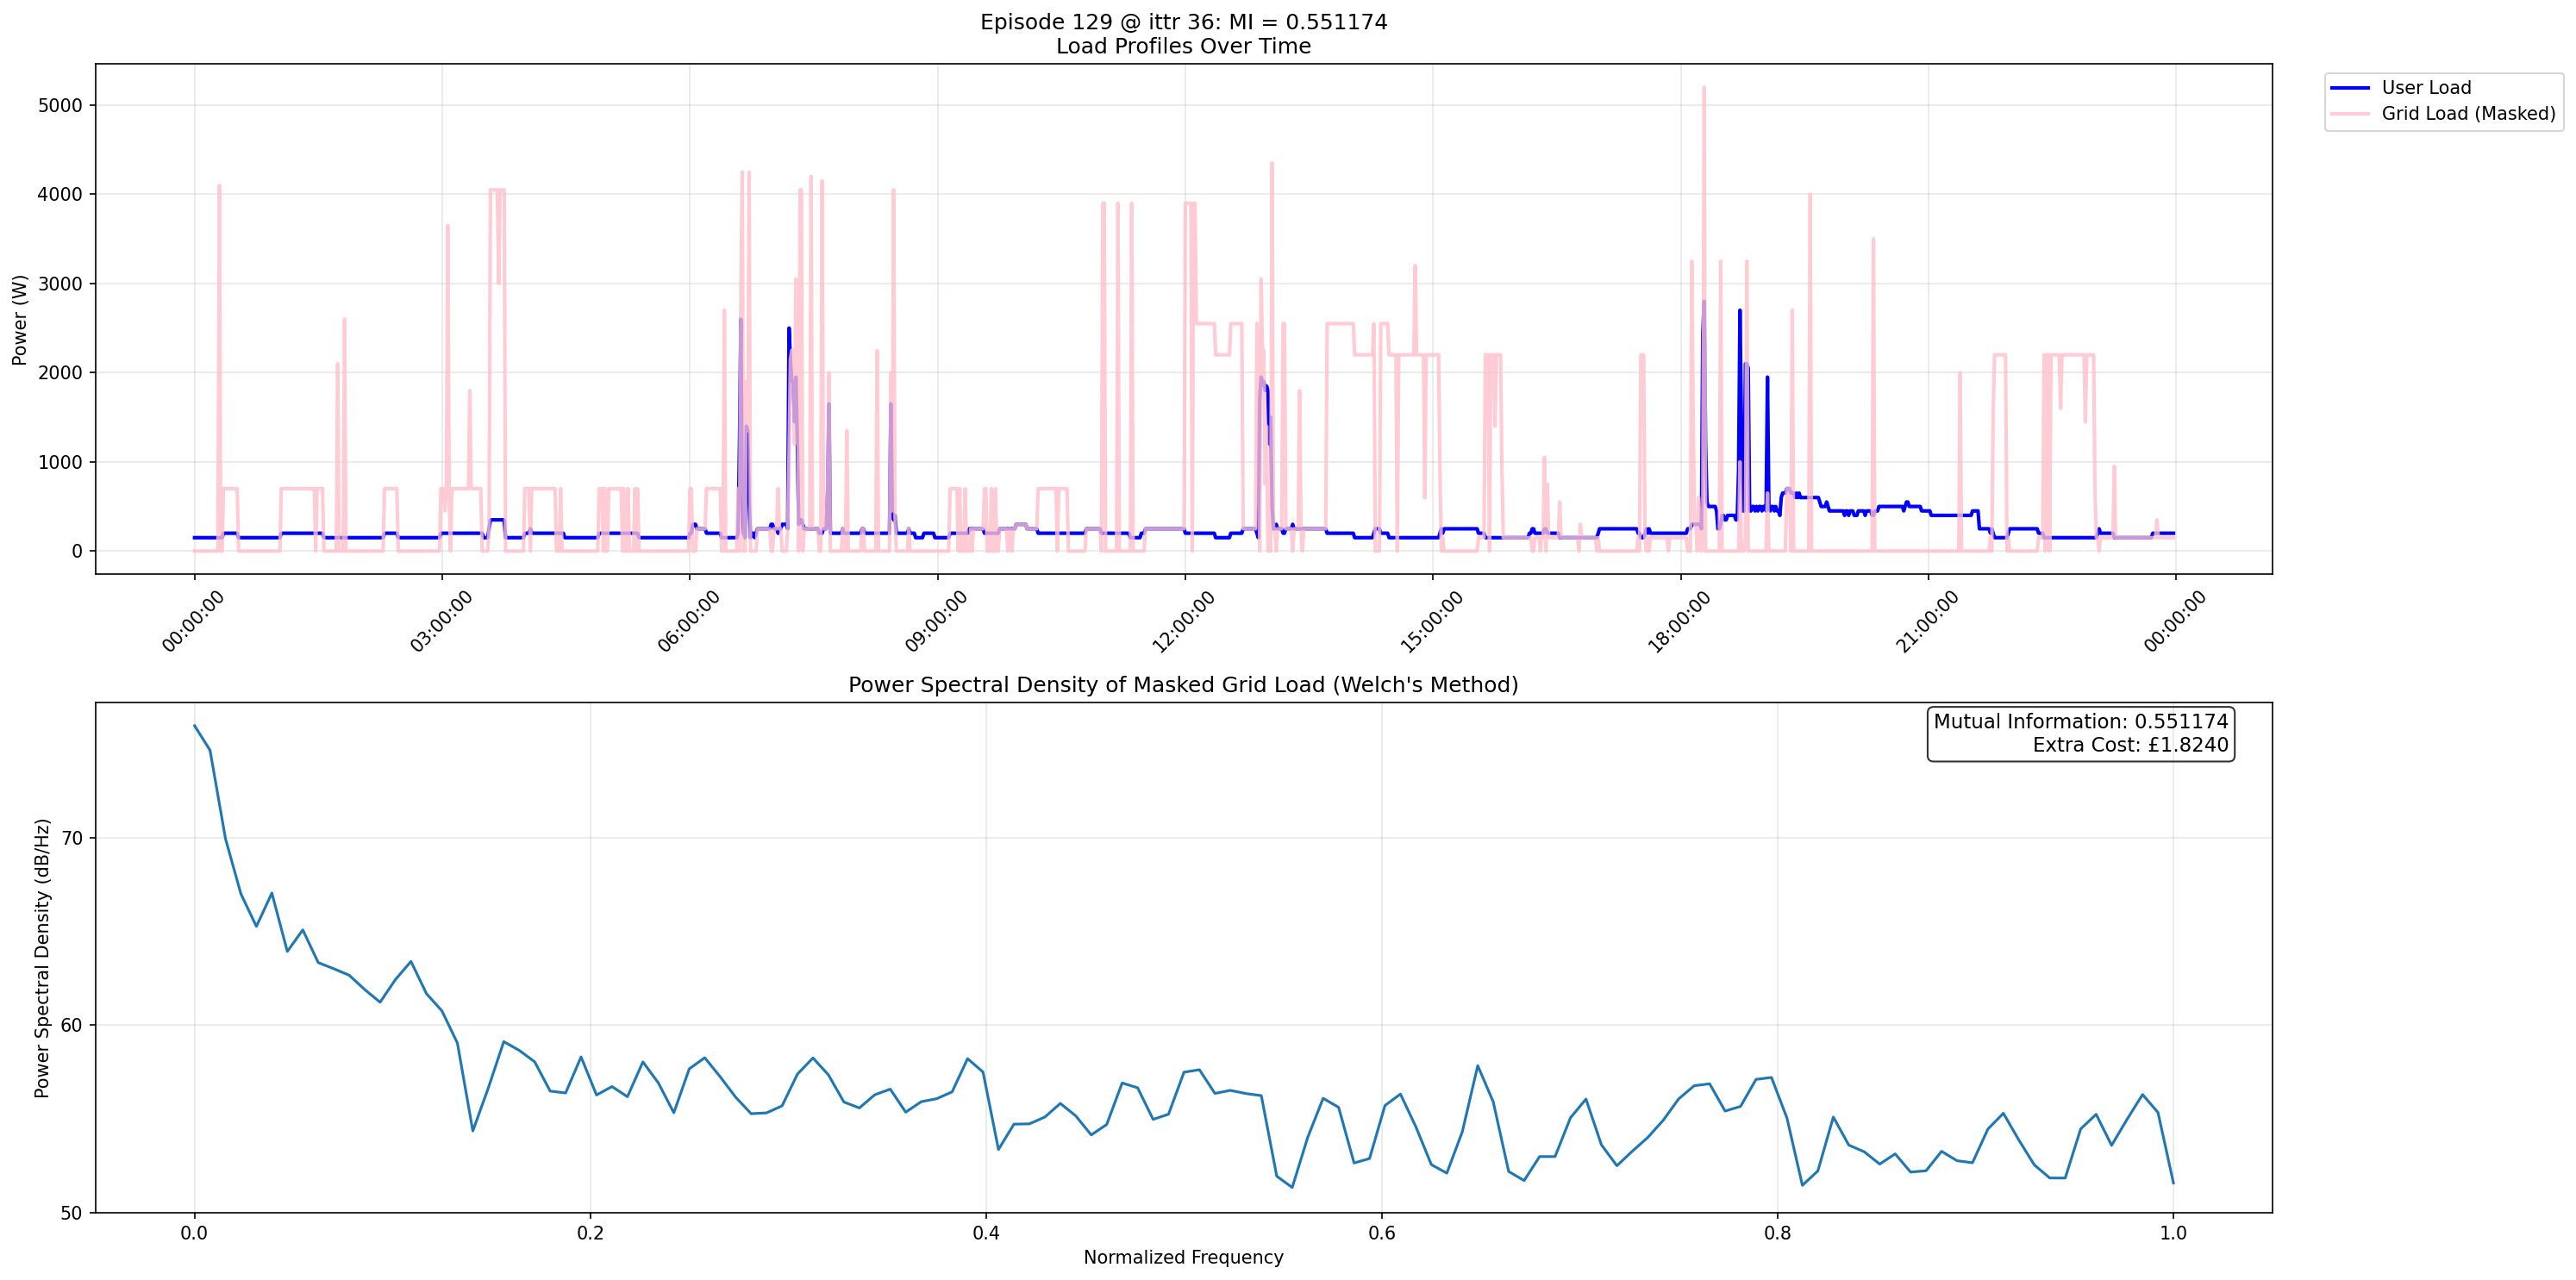

In [17]:
# Enhanced example: Plot a specific episode with curriculum information
example_episode_idx = 35  # Change this to plot different episodes

if example_episode_idx < len(episode_info_dfs):
    episode_df = episode_info_dfs[example_episode_idx]
    episode_idx = episode_df['episode_index'].iloc[0] if 'episode_index' in episode_df.columns else example_episode_idx
    mi_value = mutual_info_values[example_episode_idx]
    extra_cost = extra_cost_values[example_episode_idx]
    
    # Get curriculum information if available
    episode_length_days = 1
    curriculum_phase = None
    
    if 'episode_metadata_df' in locals():
        episode_iteration = int(episode_df['episode'].iloc[0])
        metadata = episode_metadata_df[episode_metadata_df['episode_idx'] == episode_iteration]
        if len(metadata) > 0:
            metadata_row = metadata.iloc[0]
            episode_length_days = metadata_row.get('episode_length_days', 1)
            curriculum_phase = metadata_row.get('curriculum_phase', None)
    
    print_log(f"Plotting episode {episode_idx} with enhanced curriculum information:")
    print_log(f"  MI = {mi_value:.6f}")
    print_log(f"  Extra Cost = £{extra_cost:.4f}")
    print_log(f"  Episode Length = {episode_length_days} day(s)")
    print_log(f"  Curriculum Phase = {curriculum_phase}")
    
    # Plot with enhanced curriculum information
    fig = plot_episode_with_psd_and_curriculum(
        episode_df, episode_idx, mi_value, extra_cost, 
        episode_length_days=episode_length_days,
        curriculum_phase=curriculum_phase,
        use_datetime=True, show=True
    )
    
    # Optionally save the plot
    # save_path = expt_folder / "graphs" / "mi_analysis_enhanced" / f"episode_{episode_idx}_enhanced.png"
    # if not save_path.parent.exists():
    #     save_path.parent.mkdir(parents=True)
    # fig.savefig(save_path, dpi=300, bbox_inches='tight')
    
    # plt.close('all')
else:
    print_log(f"Episode index {example_episode_idx} is out of range. Available episodes: 0 to {len(episode_info_dfs)-1}")

In [19]:
# TODO: not sure whether this graph is useful to our analysis. May be deleted later.

# Enhanced mutual information summary with curriculum learning analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12), dpi=150)

# Plot 1: MI over episodes with curriculum information
episode_indices = range(len(mutual_info_values))
ax1.plot(episode_indices, mutual_info_values, color='blue', alpha=0.3, linewidth=1, label='MI per Episode')

# Add rolling average
window_size = 100
mi_series = pd.Series(mutual_info_values)
mi_rolling = mi_series.rolling(window=window_size, min_periods=1).mean()
ax1.plot(episode_indices, mi_rolling, color='blue', linewidth=3, alpha=1.0, 
         label=f'MI Rolling Average (window={window_size})')

# Color points by episode length if available
if 'episode_metadata_df' in locals() and 'episode_length_days' in episode_metadata_df.columns:
    # Create color mapping for episode lengths
    episode_lengths = []
    for i in range(len(episode_info_dfs)):
        episode_iteration = int(episode_info_dfs[i]['episode'].iloc[0])
        metadata = episode_metadata_df[episode_metadata_df['episode_idx'] == episode_iteration]
        if len(metadata) > 0:
            episode_lengths.append(metadata.iloc[0].get('episode_length_days', 1))
        else:
            episode_lengths.append(1)
    
    # Scatter plot with episode length color coding
    scatter = ax1.scatter(episode_indices, mutual_info_values, c=episode_lengths, 
                         cmap='viridis', alpha=0.6, s=10, label='Episodes (colored by length)')
    plt.colorbar(scatter, ax=ax1, label='Episode Length (days)')

ax1.set_title('Mutual Information Across Episodes with Curriculum Information')
ax1.set_xlabel('Episode Index')
ax1.set_ylabel('Mutual Information')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: MI distribution by episode length
if 'episode_length_days' in mi_df.columns:
    for length in sorted(mi_df['episode_length_days'].unique()):
        length_data = mi_df[mi_df['episode_length_days'] == length]['mutual_information'].dropna()
        if len(length_data) > 0:
            ax2.hist(length_data, alpha=0.6, bins=20, label=f'{length}d episodes', density=True)
    
    ax2.set_title('MI Distribution by Episode Length')
    ax2.set_xlabel('Mutual Information')
    ax2.set_ylabel('Density')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'Episode length information\nnot available', 
             transform=ax2.transAxes, ha='center', va='center', fontsize=12)
    ax2.set_title('MI Distribution by Episode Length')

# Plot 3: Extra cost over episodes
ax3.plot(episode_indices, extra_cost_values, color='red', alpha=0.3, linewidth=1, label='Cost per Episode')

# Add rolling average for cost
cost_series = pd.Series(extra_cost_values)
cost_rolling = cost_series.rolling(window=window_size, min_periods=1).mean()
ax3.plot(episode_indices, cost_rolling, color='red', linewidth=3, alpha=1.0,
         label=f'Cost Rolling Average (window={window_size})')

# Color points by episode length if available
if 'episode_metadata_df' in locals():
    scatter_cost = ax3.scatter(episode_indices, extra_cost_values, c=episode_lengths, 
                              cmap='viridis', alpha=0.6, s=10, label='Episodes (colored by length)')

ax3.set_title('Extra Cost Across Episodes')
ax3.set_xlabel('Episode Index')
ax3.set_ylabel('Extra Cost ($)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Privacy-Cost Scatter Plot
valid_indices = [i for i in range(len(mutual_info_values)) 
                if not (np.isnan(mutual_info_values[i]) or np.isnan(extra_cost_values[i]))]

if len(valid_indices) > 0:
    valid_mi = [mutual_info_values[i] for i in valid_indices]
    valid_cost = [extra_cost_values[i] for i in valid_indices]
    
    if 'episode_metadata_df' in locals():
        valid_lengths = [episode_lengths[i] for i in valid_indices]
        scatter_tradeoff = ax4.scatter(valid_mi, valid_cost, c=valid_lengths, 
                                      cmap='viridis', alpha=0.7, s=30)
        plt.colorbar(scatter_tradeoff, ax=ax4, label='Episode Length (days)')
    else:
        ax4.scatter(valid_mi, valid_cost, alpha=0.7, s=30, color='purple')
    
    ax4.set_title('Privacy-Cost Tradeoff Analysis')
    ax4.set_xlabel('Mutual Information (Privacy Loss)')
    ax4.set_ylabel('Extra Cost (£)')
    ax4.grid(True, alpha=0.3)
    
    # Add trend line
    if len(valid_mi) > 1:
        z = np.polyfit(valid_mi, valid_cost, 1)
        p = np.poly1d(z)
        ax4.plot(valid_mi, p(valid_mi), "r--", alpha=0.8, linewidth=2, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
        ax4.legend()
else:
    ax4.text(0.5, 0.5, 'No valid data points\nfor tradeoff analysis', 
             transform=ax4.transAxes, ha='center', va='center', fontsize=12)

# Add overall statistics text box
stats_text = f"""Overall Statistics:
MI  - Mean: {np.nanmean(mutual_info_values):.6f}, Std: {np.nanstd(mutual_info_values):.6f}
Cost - Mean: ${np.nanmean(extra_cost_values):.4f}, Std: ${np.nanstd(extra_cost_values):.4f}
Episodes: {len(episode_info_dfs)} total"""

if 'episode_metadata_df' in locals():
    unique_lengths = sorted(episode_metadata_df['episode_length_days'].unique())
    stats_text += f"\nEpisode Lengths: {unique_lengths} days"

fig.text(0.02, 0.02, stats_text, fontsize=10, 
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()

# Save the enhanced summary plot
mi_summary_path = expt_folder / "graphs" / "enhanced_privacy_cost_analysis.png"
if not mi_summary_path.parent.exists():
    mi_summary_path.parent.mkdir(parents=True)
fig.savefig(mi_summary_path, dpi=300, bbox_inches='tight')
print_log(f"Enhanced privacy-cost analysis plot saved to: {mi_summary_path}")

plt.show()

[2025-07-27 14:26:31:724] Enhanced privacy-cost analysis plot saved to: experiments/20250727_010853/logs_train/graphs/enhanced_privacy_cost_analysis.png


/tmp/ipykernel_1057938/4119979274.py:130: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [17]:
# Enhanced function to plot multiple episodes with curriculum information
def plot_multiple_episodes_with_curriculum(episode_info_dfs, mutual_info_values, extra_cost_values, 
                                          episode_indices=None, selection_strategy='first', 
                                          save_folder=None, use_datetime=True, show_plots=False):
    """
    Plot multiple episodes with curriculum learning information and smart selection strategies
    
    Args:
        episode_info_dfs: List of episode DataFrames
        mutual_info_values: List of mutual information values
        extra_cost_values: List of extra cost values
        episode_indices: List of episode indices to plot (if None, uses selection_strategy)
        selection_strategy: 'first', 'random', 'diverse_lengths', 'best_privacy', 'worst_privacy'
        save_folder: Folder to save plots (if None, doesn't save)
        use_datetime: Whether to use datetime for x-axis
        show_plots: Whether to display plots
    """
    
    if episode_indices is None:
        # Smart episode selection based on strategy
        if selection_strategy == 'first':
            episode_indices = list(range(min(10, len(episode_info_dfs))))
            
        elif selection_strategy == 'random':
            import random
            episode_indices = random.sample(range(len(episode_info_dfs)), min(10, len(episode_info_dfs)))
            
        elif selection_strategy == 'diverse_lengths' and 'grouped_by_episode_length' in globals():
            episode_indices = []
            for length, episodes in grouped_by_episode_length.items():
                # Take 2-3 episodes from each length category
                n_episodes = min(3, len(episodes))
                episode_indices.extend(episodes[:n_episodes])
            episode_indices = episode_indices[:15]  # Limit total episodes
            
        elif selection_strategy == 'best_privacy':
            # Select episodes with lowest MI (best privacy)
            valid_mi_indices = [(i, mi) for i, mi in enumerate(mutual_info_values) if not np.isnan(mi)]
            valid_mi_indices.sort(key=lambda x: x[1])  # Sort by MI value
            episode_indices = [idx for idx, _ in valid_mi_indices[:10]]
            
        elif selection_strategy == 'worst_privacy':
            # Select episodes with highest MI (worst privacy)
            valid_mi_indices = [(i, mi) for i, mi in enumerate(mutual_info_values) if not np.isnan(mi)]
            valid_mi_indices.sort(key=lambda x: x[1], reverse=True)  # Sort by MI value descending
            episode_indices = [idx for idx, _ in valid_mi_indices[:10]]
            
        else:
            episode_indices = list(range(min(10, len(episode_info_dfs))))
    
    print_log(f"Plotting {len(episode_indices)} episodes using '{selection_strategy}' selection strategy...")
    
    for plot_idx, ep_idx in enumerate(episode_indices):
        if ep_idx >= len(episode_info_dfs):
            print_log(f"Episode index {ep_idx} out of range, skipping...")
            continue
            
        episode_df = episode_info_dfs[ep_idx]
        episode_idx = episode_df['episode_index'].iloc[0] if 'episode_index' in episode_df.columns else ep_idx
        mi_value = mutual_info_values[ep_idx]
        extra_cost = extra_cost_values[ep_idx]
        
        # Get curriculum information if available
        episode_length_days = 1
        curriculum_phase = None
        
        if 'episode_metadata_df' in locals():
            episode_iteration = int(episode_df['episode'].iloc[0])
            metadata = episode_metadata_df[episode_metadata_df['episode_idx'] == episode_iteration]
            if len(metadata) > 0:
                metadata_row = metadata.iloc[0]
                episode_length_days = metadata_row.get('episode_length_days', 1)
                curriculum_phase = metadata_row.get('curriculum_phase')
        
        # Create save path if folder provided
        save_path = None
        if save_folder:
            strategy_suffix = f"_{selection_strategy}" if selection_strategy != 'first' else ''
            save_path = save_folder / f"episode_{plot_idx + 1:04d}{strategy_suffix}_enhanced.png"
            if not save_path.parent.exists():
                save_path.parent.mkdir(parents=True)
        
        # Plot the episode with enhanced information
        fig = plot_episode_with_psd_and_curriculum(
            episode_df, episode_idx, mi_value, extra_cost,
            episode_length_days=episode_length_days,
            curriculum_phase=curriculum_phase,
            save_path=save_path, use_datetime=use_datetime, show=show_plots
        )
        
        # Close figure to save memory
        if not show_plots:
            plt.close(fig)

        if (plot_idx + 1) % 5 == 0:
            print_log(f"Completed {plot_idx + 1}/{len(episode_indices)} episodes")

# Example usage with different selection strategies
print_log("=" * 60)
print_log("ENHANCED EPISODE PLOTTING WITH CURRICULUM INFORMATION")
print_log("=" * 60)

# Strategy 1: Plot episodes with diverse episode lengths
if 'grouped_by_episode_length' in locals() and len(grouped_by_episode_length) > 1:
    print_log("\n1. Plotting episodes with diverse episode lengths...")
    diverse_folder = expt_folder / "graphs" / "MI_analysis_enhanced" / "diverse_lengths"
    plot_multiple_episodes_with_curriculum(
        episode_info_dfs, mutual_info_values, extra_cost_values,
        selection_strategy='diverse_lengths',
        save_folder=diverse_folder,
        use_datetime=True, show_plots=False
    )

# Strategy 2: Plot best privacy episodes (lowest MI)
print_log("\n2. Plotting episodes with best privacy (lowest MI)...")
best_privacy_folder = expt_folder / "graphs" / "MI_analysis_enhanced" / "best_privacy"
plot_multiple_episodes_with_curriculum(
    episode_info_dfs, mutual_info_values, extra_cost_values,
    selection_strategy='best_privacy',
    save_folder=best_privacy_folder,
    use_datetime=True, show_plots=False
)

# Strategy 3: Plot worst privacy episodes (highest MI)
print_log("\n3. Plotting episodes with worst privacy (highest MI)...")
worst_privacy_folder = expt_folder / "graphs" / "MI_analysis_enhanced" / "worst_privacy"
plot_multiple_episodes_with_curriculum(
    episode_info_dfs, mutual_info_values, extra_cost_values,
    selection_strategy='worst_privacy',
    save_folder=worst_privacy_folder,
    use_datetime=True, show_plots=False
)

# Strategy 4: Plot all episodes (for comprehensive analysis)
print_log("\n4. Plotting all episodes with enhanced curriculum information...")
all_episodes_folder = expt_folder / "graphs" / "MI_analysis_enhanced" / "all_episodes"
plot_multiple_episodes_with_curriculum(
    episode_info_dfs, mutual_info_values, extra_cost_values,
    episode_indices=list(range(len(episode_info_dfs))),
    save_folder=all_episodes_folder,
    use_datetime=True, show_plots=False
)

print_log(f"\nEnhanced episode plots with curriculum information saved to: {expt_folder / 'graphs' / 'MI_analysis_enhanced'}")
print_log("Available analysis categories:")
print_log("  - diverse_lengths: Episodes representing different curriculum phases")
print_log("  - best_privacy: Episodes with lowest mutual information")
print_log("  - worst_privacy: Episodes with highest mutual information")
print_log("  - all_episodes: Complete dataset analysis")

[2025-07-27 14:18:55:323] ============================================================
[2025-07-27 14:18:55:323] ENHANCED EPISODE PLOTTING WITH CURRICULUM INFORMATION
[2025-07-27 14:18:55:323] ============================================================
[2025-07-27 14:18:55:323] 
2. Plotting episodes with best privacy (lowest MI)...
[2025-07-27 14:18:55:323] Plotting 10 episodes using 'best_privacy' selection strategy...
[2025-07-27 14:18:57:996] Completed 5/10 episodes
[2025-07-27 14:19:00:727] Completed 10/10 episodes
[2025-07-27 14:19:00:727] 
3. Plotting episodes with worst privacy (highest MI)...
[2025-07-27 14:19:00:727] Plotting 10 episodes using 'worst_privacy' selection strategy...
[2025-07-27 14:19:03:386] Completed 5/10 episodes
[2025-07-27 14:19:05:929] Completed 10/10 episodes
[2025-07-27 14:19:05:929] 
4. Plotting all episodes with enhanced curriculum information...
[2025-07-27 14:19:05:930] Plotting 605 episodes using 'first' selection strategy...
[2025-07-27 14:19:08:52

## Enhanced Mutual Information & Cost Analysis with Curriculum Learning

The enhanced evaluation provides comprehensive privacy-cost analysis with curriculum learning support:

### 🔐 **Privacy Metrics (Mutual Information)**
- **MI = 0**: Perfect privacy - masked grid load reveals no information about user load
- **Higher MI values**: More information leakage - masking is less effective
- **Curriculum Progression**: Shows how privacy protection evolves across different episode difficulties

### 💰 **Cost Metrics (Extra Electricity Cost)**
- **Extra Cost**: Additional expense incurred by battery operations for privacy protection
- **Cost Efficiency**: Extra cost per day (normalized by episode length)
- **Privacy-Cost Tradeoff**: Balance between information protection and operational expense

### 📊 **Curriculum Learning Analysis**

#### **Episode Length Analysis**
- **1-day episodes**: Baseline difficulty, typically used for initial learning
- **Multi-day episodes**: Increased complexity, tests agent's long-term planning
- **Length Progression**: Gradual introduction of longer episodes improves learning

#### **Curriculum Phase Tracking**
- **Phase 1-2**: Focus on 1-day episodes (foundation building)
- **Phase 3-4**: Introduction of 2-3 day episodes (skill expansion)
- **Phase 5**: Complex 4-5 day episodes (mastery testing)

#### **Content-Based Evaluation**
- **Repeated Episodes**: Same episode content at different training stages
- **Learning Progress**: Performance improvement on identical scenarios
- **Consistency**: Stable privacy-cost balance across repetitions

### 🎯 **Key Insights**

1. **Privacy Evolution**: 
   - Early training may show higher MI (learning phase)
   - Mature agents achieve lower MI (better privacy protection)
   - Episode length affects privacy complexity

2. **Cost Efficiency**:
   - Longer episodes may show better cost amortization
   - Curriculum learning helps optimize cost-privacy balance
   - Phase progression reveals learning efficiency

3. **Curriculum Effectiveness**:
   - Gradual difficulty increase improves final performance
   - Episode length diversity enhances robustness
   - Content repetition validates learning consistency

### 📈 **Evaluation Outputs**

The enhanced analysis generates:
- **Privacy-cost tradeoff plots** by episode length
- **Curriculum progression analysis** across training phases
- **Repeated content performance** tracking learning improvement
- **Smart episode selection** for targeted analysis (best/worst privacy, diverse lengths)

This comprehensive evaluation framework enables thorough assessment of adversarial smart meter control systems with curriculum learning, providing insights into both privacy protection effectiveness and operational cost efficiency across varying episode complexities.

In [ ]:
# ===== CURRICULUM LEARNING EVALUATION INTEGRATION SUMMARY =====

print_log("=" * 80)
print_log("CURRICULUM LEARNING EVALUATION INTEGRATION COMPLETE")
print_log("=" * 80)

print_log("\n🎓 Enhanced Evaluation Capabilities:")
print_log("✅ Episode metadata loading with content IDs and curriculum information")
print_log("✅ Curriculum-aware episode grouping (by content, length, phase)")
print_log("✅ Privacy analysis (MI) across different episode complexities")
print_log("✅ Cost analysis with episode length normalization")
print_log("✅ Privacy-cost tradeoff analysis by curriculum parameters")
print_log("✅ Learning progression tracking across training phases")
print_log("✅ Repeated content performance evaluation")
print_log("✅ Smart episode selection strategies for targeted analysis")

print_log("\n📊 Analysis Dimensions Added:")
print_log(f"🔢 Episode Lengths: {list(grouped_by_episode_length.keys()) if 'grouped_by_episode_length' in locals() else ['Not available']}")
print_log(f"🎯 Curriculum Phases: {list(grouped_by_curriculum_phase.keys()) if 'grouped_by_curriculum_phase' in locals() else ['Not available']}")
print_log(f"🔄 Content Groups: {len(grouped_by_content_id)} unique episode contents" if 'grouped_by_content_id' in locals() else "🔄 Content Groups: Not available")

print_log("\n📈 Generated Analyses:")
if 'tradeoff_by_length' in locals() and tradeoff_by_length is not None:
    print_log("✅ Privacy-cost tradeoff by episode length")
if 'curriculum_progression' in locals() and curriculum_progression is not None:
    print_log("✅ Curriculum progression analysis")
if 'repeated_content_analysis' in locals() and repeated_content_analysis is not None:
    print_log("✅ Repeated content performance tracking")
print_log("✅ Enhanced privacy-cost visualization with curriculum info")
print_log("✅ Smart episode selection and plotting")

print_log("\n📂 Enhanced Output Structure:")
print_log("📁 graphs/enhanced_privacy_cost_analysis.png - Comprehensive 4-panel analysis")
print_log("📁 graphs/MI_analysis_enhanced/")
print_log("   ├── diverse_lengths/ - Episodes across different curriculum phases")
print_log("   ├── best_privacy/ - Episodes with optimal privacy protection")
print_log("   ├── worst_privacy/ - Episodes requiring improvement")
print_log("   └── all_episodes/ - Complete dataset analysis")

print_log("\n🔍 Integration Benefits:")
print_log("• Episode content identification enables cross-training-stage comparisons")
print_log("• Episode length analysis validates curriculum learning effectiveness")
print_log("• Curriculum phase tracking shows privacy-cost learning progression")
print_log("• Smart selection strategies provide targeted evaluation insights")
print_log("• Enhanced visualizations support research presentations and papers")

print_log("\n🎯 Evaluation Framework Ready!")
print_log("The notebook now supports both SimpleSmartMeterDataLoader and")
print_log("CurriculumSmartMeterDataLoader for comprehensive privacy-cost evaluation")
print_log("with full curriculum learning analysis capabilities.")
print_log("=" * 80)